In [139]:
# Import all possible libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

In [140]:
# Load the data and print it

df = pd.read_csv('UsArrests.csv')
df

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.20,236,58,21.20
1,Alaska,10.00,263,48,44.50
2,Arizona,8.10,294,80,31.00
3,Arkansas,8.80,190,50,19.50
4,California,9.00,276,91,40.60
5,Colorado,7.90,204,78,38.70
6,Connecticut,3.30,110,77,11.10
7,Delaware,5.90,238,72,15.80
8,Florida,15.40,335,80,31.90
9,Georgia,17.40,211,60,25.80


We have 50 cases with 4 features. There are no null values.

In [141]:
# Correct the first column name - it shows states not cities

df.rename(columns = {'City':'State'}, inplace = True)

# Make State the index

df.set_index('State')
df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.20,236,58,21.20
1,Alaska,10.00,263,48,44.50
2,Arizona,8.10,294,80,31.00
3,Arkansas,8.80,190,50,19.50
4,California,9.00,276,91,40.60


In [142]:
# Check the data types

df.dtypes

State        object
Murder      float64
Assault       int64
UrbanPop      int64
Rape        float64
dtype: object

The 4 features are all numerical, so their types don't need to be changed.

In [143]:
# Summarise the statistical properties of the columns

# Set the decimal precision
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# Use the describe function
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose()
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


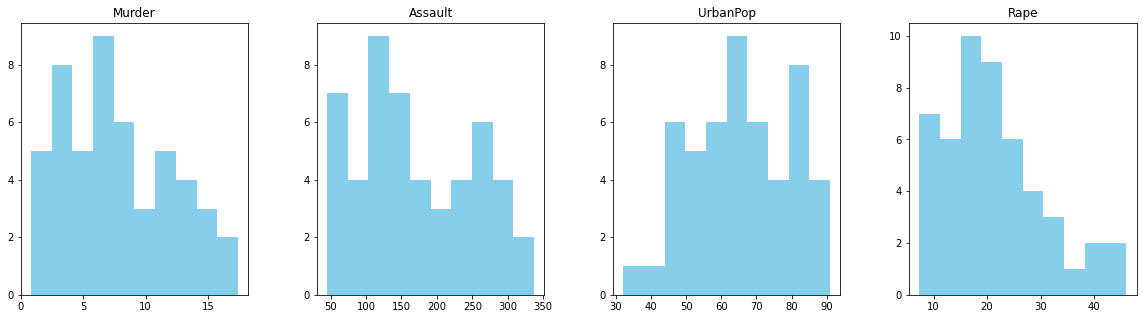

In [144]:
# Plot histograms of all features

histograms = df.hist(color='skyblue', grid=False, layout=(1,4), figsize=(20, 5))
plt.show()

The Assault variable stands out, as having a high standard deviation and wide range. This will need to be scaled.

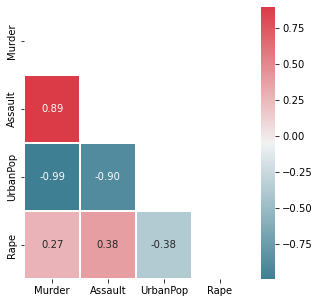

In [145]:
# Conduct correlation analysis

# Define the data to analyse and labels to use
corr_df = df.drop(["State"],axis=1).corr()
labels = corr_df.columns
corrs = corr_df.corr()

# Pick appropriate palette for heatmap
    
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Define function to generate the Heat Map

def corr_heatmap(df):

  # Plot figsize
  fig, ax = plt.subplots(figsize=(5, 5))

  # Mask mirrored side of heatmap
  dropSelf = np.zeros_like(corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True

  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

  plt.show()

# Run the function on the data frame

corr_heatmap(df)

The heatmap shows that there is a strong positive correlation between Assault and Murder, as well as less strong positive ones between Assault and Rape, and Rape and Murder. This is intuitive - they're all associated violent crimes, so states with a high rate in one are likely to have a high rate in the others.

The correlation between Urban Population and all three crime types is negative, and strong for Murder and Assault - so as population goes up, crime goes down. This is perhaps counterintuitive, as you'd expect higher rates of violent crime in bigger cities. 

However, the data is for "arrests per 100,000 residents". So the fact that the data is per capita, rather than absolute, might negate this effect. Or it might also point to differences in the quality of policing between urban and rural areas, in terms of crime deterrents and arrest rates.

In [146]:
# Conduct principal components analysis

from sklearn.decomposition import PCA

np.set_printoptions(precision=2)

X = df.drop(["State"],axis=1).values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


In [147]:
# Standardise the data, to reduce the impact of the Assault variable

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.99,1.13,-0.44,0.16
1,1.95,1.07,2.04,-0.44
2,1.76,-0.75,0.05,-0.83
3,-0.14,1.12,0.11,-0.18
4,2.52,-1.54,0.60,-0.34


In [148]:
# Define a function to create a biplot of the principal components

states = df['State']

def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

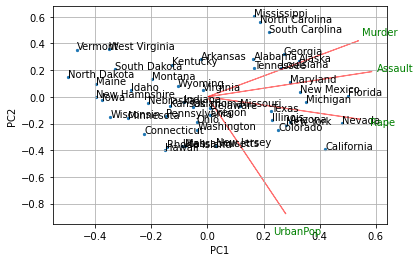

In [149]:
# Run the biplot funtion on the standardised data

biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

In [150]:
# Look at the feature importance to the two principal components

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.54,0.42
1,Assault,0.58,0.19
2,UrbanPop,0.28,0.87
3,Rape,0.54,0.17


The first principal component is most influenced by the crimes themselves, with Assault, Murder and Rape all having a similarly high importance relative to Urban Population. Meanwhile, the second principal component is most influenced by Urban Population.

This can clearly be seen in the biplot.

States are separated left to right, based on crime levels. Those with crime levels close to the minimum value from earlier are on the left. Those with levels close to the maximum are on the right.

If we look vertically, then we can see states with a lower Urban Population are at the top, while those with a higher value are at the bottom.

This mirrors the relationships we saw in the heatmap earlier.

Text(0.5, 1.0, 'Cumulative Explained Variance')

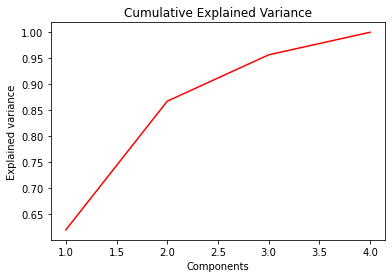

In [151]:
# Create a cumulative variance plot

plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

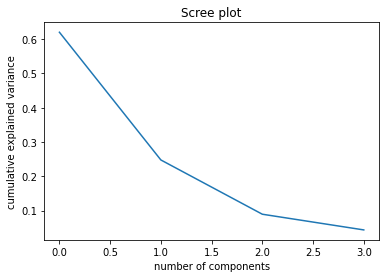

In [152]:
# Create a scree plot

plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first three principal components together explain around 90% of the variance. We can therefore use them to perform cluster analysis.

In [153]:
# Create a data frame of the three components and State names

pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df['State'])
pca_df.head()

,0,1,2
State,,,
Alabama,0.99,1.13,-0.44
Alaska,1.95,1.07,2.04
Arizona,1.76,-0.75,0.05
Arkansas,-0.14,1.12,0.11
California,2.52,-1.54,0.60


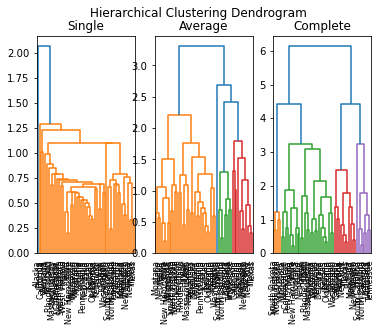

In [154]:
# Perform the cluster analysis using the three different methods

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1)
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

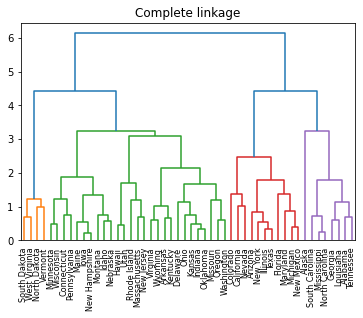

In [155]:
# The Complete method results in the most balanced cluster sizes, so let's use that

plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

The states in each cluster are similar to those in each quadrant of the biplot earlier, which suggests the model is suitable.

Text(0, 0.5, 'Dim 1')

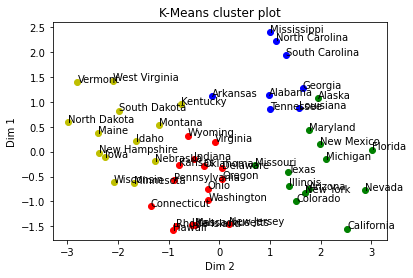

In [156]:
# Run K-means clustering using k=4 (the number of clusters from above)

from sklearn.cluster import KMeans

# Extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

The K-Means clusters are similar to those in the cluster analysis, but more balanced in size. Looking at the clusters, there are some geographic commonalities between them. We could conclude that:

+ **Blue states** (higher crime, lower urban population) are mostly in the Deep South
+ **Dark green states** (higher crime, higher urban population) are mostly those with major cities
+ **Light green states** (lower crime, lower urban population) are mostly in the Midwest and North Eastern parts of the US
+ **Red states** (lower crime, low-to-mid urban population) are mostly in the Midwest and North Western parts of the US.